# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [108]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [109]:
RANDOM_STATE = 110

train_data = pd.read_csv("../../data/trim_train_data.csv")

In [110]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(342), int64(88), object(34)
memory usage: 143.4+ MB


In [111]:
# excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
for col in train_data.columns:
    counts = train_data[col].value_counts()
    print(f"Value counts for column {col}:")
    print(counts)
    print()

Value counts for column Wip Line_Dam:
IVI-OB6    40506
Name: Wip Line_Dam, dtype: int64

Value counts for column Process Desc._Dam:
Dam Dispenser    40506
Name: Process Desc._Dam, dtype: int64

Value counts for column Equipment_Dam:
Dam dispenser #1    25030
Dam dispenser #2    15476
Name: Equipment_Dam, dtype: int64

Value counts for column Model.Suffix_Dam:
AJX75334501    33820
AJX75334502     3390
AJX75334505     2635
AJX75334507      310
AJX75334503      162
AJX75334506      129
AJX75334508       60
Name: Model.Suffix_Dam, dtype: int64

Value counts for column Workorder_Dam:
3L1X8574-2       272
3K1XC268-1       227
3L1X9934-1       217
3L1X8506-1       217
3K1XA586-2       189
                ... 
4BPM0084-1         2
3FPXX064-0003      2
3H1XB714-1         1
4CPM0166-1         1
3HPM0061-1         1
Name: Workorder_Dam, Length: 663, dtype: int64

Value counts for column Insp. Seq No._Dam:
1    40506
Name: Insp. Seq No._Dam, dtype: int64

Value counts for column Insp Judge Code_Da

In [112]:
# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')

# 제거 후 데이터 확인
print("All columns with only NaN values have been removed.")

All columns with only NaN values have been removed.


In [113]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 186 entries, Wip Line_Dam to target
dtypes: float64(64), int64(88), object(34)
memory usage: 57.5+ MB


In [114]:
# # excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
# for col in train_data.columns:
#     counts = train_data[col].value_counts()
#     print(f"Value counts for column {col}:")
#     print(counts)
#     print()

In [115]:
wip_line_columns = train_data.filter(like='Wip Line').columns

new_df = train_data.filter(items=wip_line_columns)

new_df.value_counts()

Wip Line_Dam  Wip Line_AutoClave  Wip Line_Fill1  Wip Line_Fill2
IVI-OB6       IVI-OB6             IVI-OB6         IVI-OB6           40506
dtype: int64

In [116]:
train_data.drop(columns=wip_line_columns, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 182 entries, Process Desc._Dam to target
dtypes: float64(64), int64(88), object(30)
memory usage: 56.2+ MB


In [117]:
Process_Desc_col = train_data.filter(like='Process Desc').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Process Desc._Dam  Process Desc._AutoClave  Process Desc._Fill1  Process Desc._Fill2
Dam Dispenser      Auto Clave Out           Fill1 Dispenser      Fill2 Dispenser        40506
dtype: int64

In [118]:
train_data = train_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])

In [119]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
new3_df = train_data.filter(items=Equipment_col)

# target 변수 추가
new3_df['target'] = train_data['target']

# 그룹별로 target 변수의 비율 계산
target_ratio = new3_df.groupby(list(Equipment_col))['target'].value_counts(normalize=True).unstack().fillna(0)

# AbNormal 비율 출력
abnormal_ratio = target_ratio.get('AbNormal', 0)
print("각 그룹의 abnormal_ratio:")
print(abnormal_ratio)

# 각 그룹에 값의 갯수 출력
group_counts = new3_df.groupby(list(Equipment_col)).size()
print("각 그룹의 값의 갯수:")
print(group_counts)


각 그룹의 abnormal_ratio:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    0.058614
                                                           Fill2 dispenser #2    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #2    1.000000
Dam dispenser #2  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #1    1.000000
                                                           Fill2 dispenser #2    0.054977
Name: AbNormal, dtype: float64
각 그룹의 값의 갯수:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    25011
                                                           Fill2 dispenser #2        6
                                       Fill1 dispenser #2  Fill2

In [120]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
new3_df = train_data.filter(items=Equipment_col)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new3_df.apply(determine_equipment_same_num, axis=1)
train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])


In [121]:
Process_Desc_col = train_data.filter(like='Model.Suffix').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Model.Suffix_Dam  Model.Suffix_AutoClave  Model.Suffix_Fill1  Model.Suffix_Fill2
AJX75334501       AJX75334501             AJX75334501         AJX75334501           33820
AJX75334502       AJX75334502             AJX75334502         AJX75334502            3390
AJX75334505       AJX75334505             AJX75334505         AJX75334505            2635
AJX75334507       AJX75334507             AJX75334507         AJX75334507             310
AJX75334503       AJX75334503             AJX75334503         AJX75334503             162
AJX75334506       AJX75334506             AJX75334506         AJX75334506             129
AJX75334508       AJX75334508             AJX75334508         AJX75334508              60
dtype: int64

In [122]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [123]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 172 entries, Model.Suffix to Equipment_same_num
dtypes: float64(64), int64(89), object(19)
memory usage: 53.2+ MB


In [124]:
# Workorder로 시작하는 열 필터링
workorder_cols = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# Workorder 열들로 이루어진 데이터프레임 생성
workorder_df = train_data[workorder_cols]

# 4개의 변수의 값이 모두 동일하지 않은 행 필터링
different_workorders = workorder_df[
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_AutoClave']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_Fill1'] != workorder_df['Workorder_Fill2'])
]

# 결과 출력
print("4개의 변수의 값이 모두 동일하지 않은 경우:")
print(different_workorders)

4개의 변수의 값이 모두 동일하지 않은 경우:
Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []


In [125]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Workorder_Dam': 'Workorder'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [126]:
len(train_data.iloc[:,0])

40506

In [127]:
train_data['Insp. Seq No._AutoClave'].value_counts()

1    40506
Name: Insp. Seq No._AutoClave, dtype: int64

In [128]:
Process_Desc_col = train_data.filter(like='Insp. Seq No.').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Insp. Seq No._Dam  Insp. Seq No._AutoClave  Insp. Seq No._Fill1  Insp. Seq No._Fill2
1                  1                        1                    1                      40506
dtype: int64

In [129]:
train_data = train_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])

In [130]:
Process_Desc_col = train_data.filter(like='Insp Judge Code').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Insp Judge Code_Dam  Insp Judge Code_AutoClave  Insp Judge Code_Fill1  Insp Judge Code_Fill2
OK                   OK                         OK                     OK                       40506
dtype: int64

In [131]:
train_data = train_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])

In [132]:
# 값의 종류가 1개이면서 값의 종류 갯수가 40506인 열 제거
columns_to_drop = [col for col in train_data.columns if train_data[col].nunique() == 1 and train_data[col].count() == 40506]

# 열 제거
train_data = train_data.drop(columns=columns_to_drop)

# 결과 출력
print("제거된 열 목록:")
for i in range(0, len(columns_to_drop), 3):
    print(columns_to_drop[i:i+3])

# 제거된 열의 개수 출력
print("제거된 열의 개수:", len(columns_to_drop))

제거된 열 목록:
['CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION ? Collect Result_Dam']
['CURE START POSITION Z Collect Result_Dam', 'HEAD Standby Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam']
['HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam']
['Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Zero Position X Collect Result_Dam']
['1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave']
['HEAD Standby Position X Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1']
['Head Clean Position X Collect Result_Fill1', 'Head Clean Position Y Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill1']
['Head Purge Position X Collect Result_Fill1', '

In [133]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 119 entries, Model.Suffix to Equipment_same_num
dtypes: float64(58), int64(52), object(9)
memory usage: 36.8+ MB


## AutoClave

In [134]:
# train_data의 칼럼 이름 출력
print("train_data의 칼럼 이름:")
columns = train_data.columns.to_list()

# 한 줄에 3개의 변수씩 출력
for i in range(0, len(columns), 3):
    print(columns[i:i+3])

train_data의 칼럼 이름:
['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam']
['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION ? Collect Result_Dam', 'CURE SPEED Collect Result_Dam']
['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION ? Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam']
['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
['Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Res

In [135]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [136]:
train_data['1st_Pressure_multiply']  = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave']

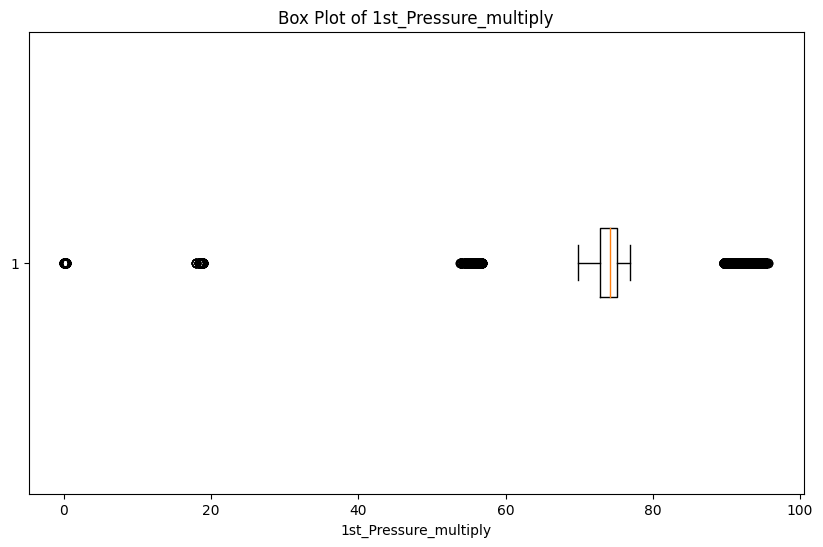

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['1st_Pressure_multiply'], vert=False)
plt.xlabel('1st_Pressure_multiply')
plt.title('Box Plot of 1st_Pressure_multiply')
plt.show()

In [138]:
train_data['1st_Pressure_multiply'].describe()

count    40506.000000
mean        75.235305
std          6.784385
min          0.000000
25%         72.782000
50%         74.228000
75%         75.192000
max         95.700000
Name: 1st_Pressure_multiply, dtype: float64

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0-10                 6      56
10-20               36      29
20-90             2005   34981


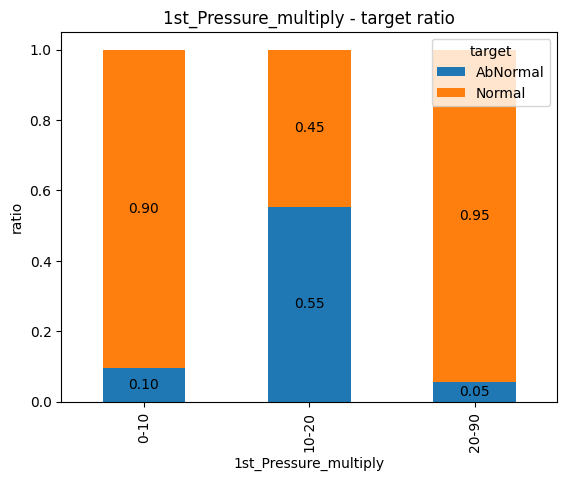

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# 1st_Pressure_multiply 값을 구간으로 나누기
bins = [0, 10, 20, 90]
labels = ['0-10', '10-20', '20-90']
train_data['Pressure_Bin'] = pd.cut(train_data['1st_Pressure_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('1st_Pressure_multiply')
plt.ylabel('ratio')
plt.title('1st_Pressure_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [140]:
train_data['2nd_Pressure_multiply']  = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave']

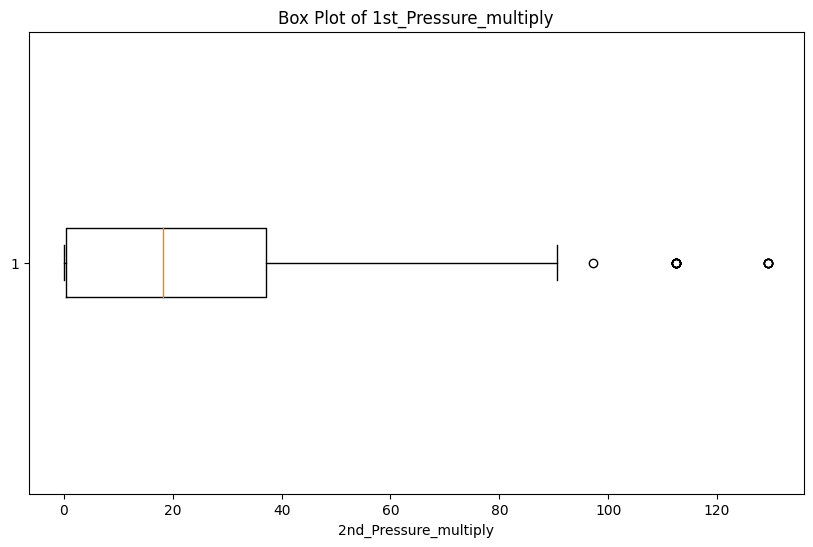

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 예시 (실제 데이터로 대체하세요)
# train_data = pd.read_csv('your_data.csv')

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['2nd_Pressure_multiply'], vert=False)
plt.xlabel('2nd_Pressure_multiply')
plt.title('Box Plot of 1st_Pressure_multiply')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0-30              1321   23306
30-60              926   13577
60-90              100    1235
90-120               3      33


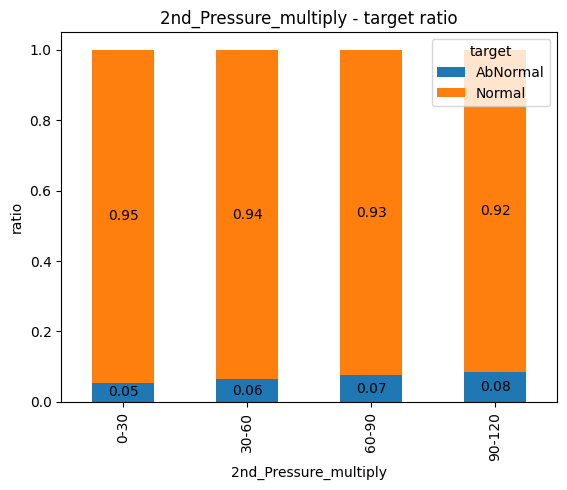

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# 1st_Pressure_multiply 값을 구간으로 나누기
bins = [0, 30, 60, 90, 120]
labels = ['0-30', '30-60', '60-90', '90-120']
train_data['Pressure_Bin'] = pd.cut(train_data['2nd_Pressure_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('2nd_Pressure_multiply')
plt.ylabel('ratio')
plt.title('2nd_Pressure_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [143]:
train_data['3rd_Pressure_multiply']  = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave']

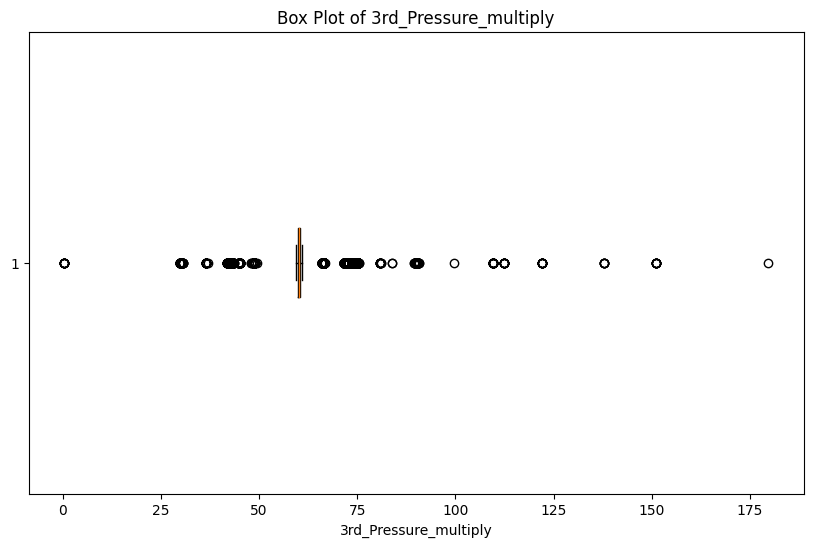

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 예시 (실제 데이터로 대체하세요)
# train_data = pd.read_csv('your_data.csv')

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['3rd_Pressure_multiply'], vert=False)
plt.xlabel('3rd_Pressure_multiply')
plt.title('Box Plot of 3rd_Pressure_multiply')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0-30                 9      40
30-60              662    8637
60-90             1670   29290
90-120               9     164
120-150              0      16
150-180              0       9


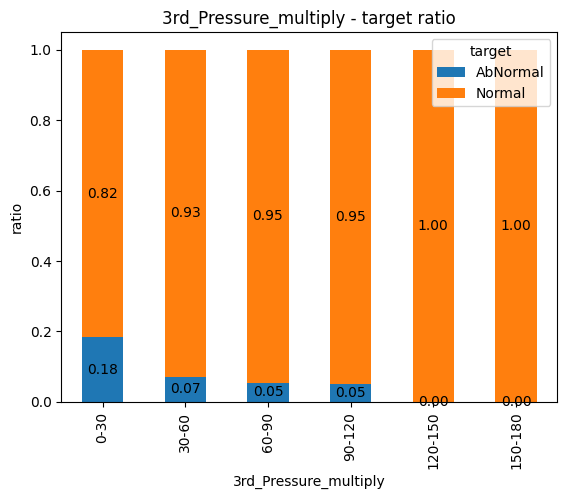

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# 1st_Pressure_multiply 값을 구간으로 나누기
bins = [0, 30, 60, 90, 120, 150, 180]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180']
train_data['Pressure_Bin'] = pd.cut(train_data['3rd_Pressure_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('3rd_Pressure_multiply')
plt.ylabel('ratio')
plt.title('3rd_Pressure_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [146]:
train_data['All_Pressure_multiply'] = train_data['1st_Pressure_multiply'] + train_data['2nd_Pressure_multiply'] + train_data['3rd_Pressure_multiply']

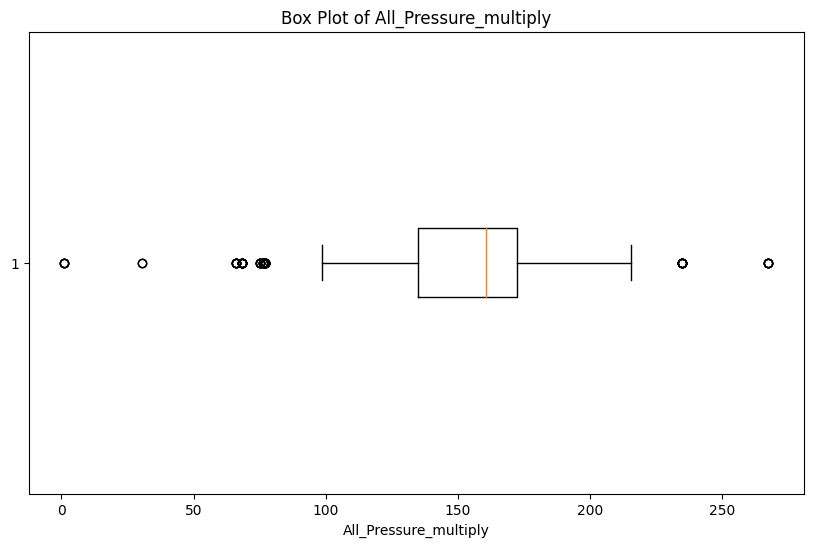

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['All_Pressure_multiply'], vert=False)
plt.xlabel('All_Pressure_multiply')
plt.title('Box Plot of All_Pressure_multiply')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0-30                 0       4
30-60                2       0
60-90               34      15
90-120               4      80
120-150            933   18286
150-180            957   15311


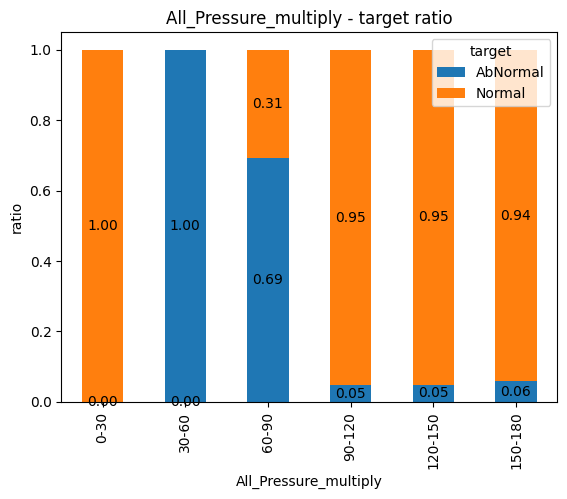

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# 1st_Pressure_multiply 값을 구간으로 나누기
bins = [0, 30, 60, 90, 120, 150, 180]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180']
train_data['Pressure_Bin'] = pd.cut(train_data['All_Pressure_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('All_Pressure_multiply')
plt.ylabel('ratio')
plt.title('All_Pressure_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [149]:
train_data['Chamber_Temp_multiply']  = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']

In [150]:
train_data['Chamber_Temp_multiply'].describe()

count    40506.000000
mean     21921.554041
std       3402.621983
min        147.000000
25%      19133.000000
50%      22560.000000
75%      25088.000000
max      31320.000000
Name: Chamber_Temp_multiply, dtype: float64

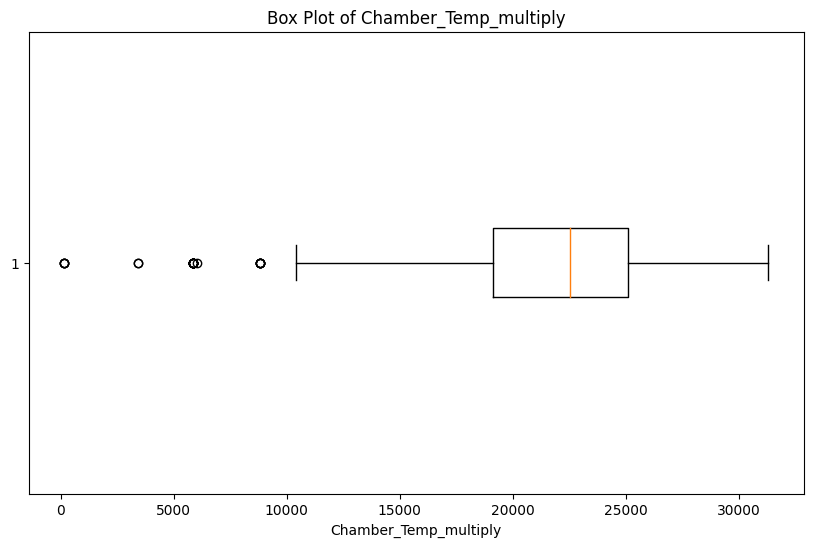

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['Chamber_Temp_multiply'], vert=False)
plt.xlabel('Chamber_Temp_multiply')
plt.title('Box Plot of Chamber_Temp_multiply')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target            AbNormal  Normal
Chamber_Temp_Bin                  
0-5000                   2       4
5000-10000              19       1
10000-15000             22      98
15000-20000            874   16711
20000-25000            773   11765
25000-30000            658    9558


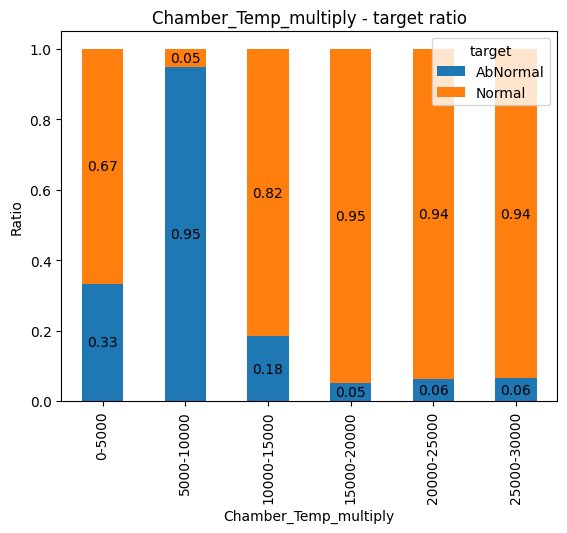

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

# Chamber_Temp_multiply 값을 구간으로 나누기
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', '25000-30000']

# Chamber_Temp_multiply 값을 구간으로 나누기
train_data['Chamber_Temp_Bin'] = pd.cut(train_data['Chamber_Temp_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
chamber_target_counts = train_data.groupby('Chamber_Temp_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
chamber_target_counts_counts = train_data.groupby('Chamber_Temp_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(chamber_target_counts_counts)

# 막대그래프로 시각화
ax = chamber_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('Chamber_Temp_multiply')
plt.ylabel('Ratio')
plt.title('Chamber_Temp_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()


In [153]:
train_data['Chamber Temp. Judge Value_AutoClave'].value_counts()

OK    29112
NG    11394
Name: Chamber Temp. Judge Value_AutoClave, dtype: int64

In [154]:
train_data['mix_variable'] =  train_data['Chamber_Temp_multiply'] / train_data['All_Pressure_multiply'] 

In [155]:
train_data['mix_variable'].describe()

count    40506.000000
mean       140.600173
std         10.028602
min         61.355293
25%        133.584119
50%        141.337510
75%        148.148148
max        184.466019
Name: mix_variable, dtype: float64

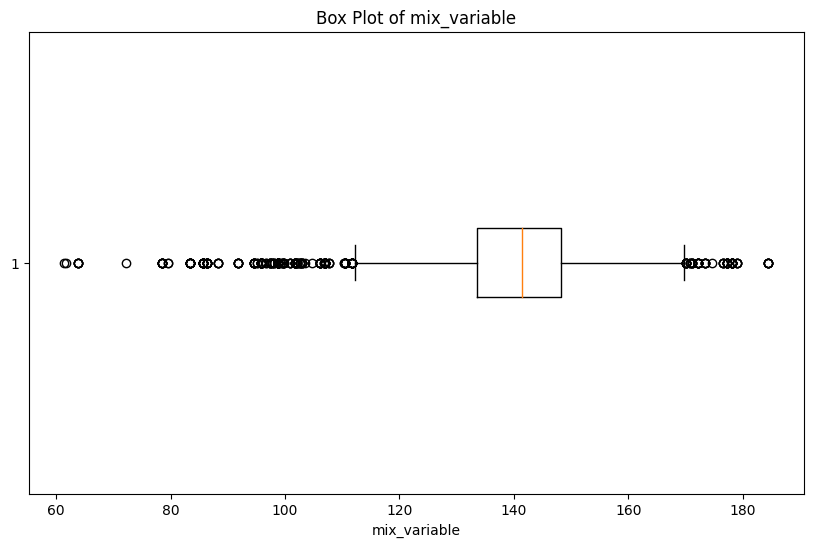

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['mix_variable'], vert=False)
plt.xlabel('mix_variable')
plt.title('Box Plot of mix_variable')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target            AbNormal  Normal
mix_variable_Bin                  
60-80                    2      16
80-100                  17      89
100-120                 76     651
120-140               1043   16676
140-160               1193   20508
160-180                 19     210
180-200                  0       6


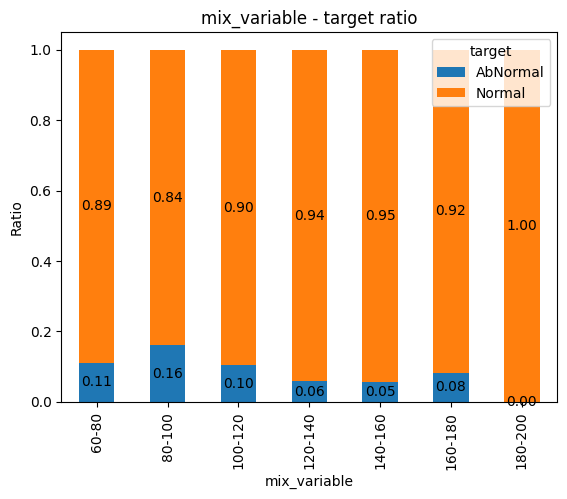

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# mix_variable_Bin 값을 구간으로 나누기
bins = [60, 80, 100, 120, 140, 160, 180, 200]
labels = ['60-80', '80-100', '100-120', '120-140', '140-160', '160-180', '180-200']

# mix_variable_Bin 값을 구간으로 나누기
train_data['mix_variable_Bin'] = pd.cut(train_data['mix_variable'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
chamber_target_counts = train_data.groupby('mix_variable_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
chamber_target_counts_counts = train_data.groupby('mix_variable_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(chamber_target_counts_counts)

# 막대그래프로 시각화
ax = chamber_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('mix_variable')
plt.ylabel('Ratio')
plt.title('mix_variable - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()


In [158]:
grouped_counts = train_data.groupby(['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave']).size()
print(grouped_counts)

GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave  GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
OK                                                    OK                                                   11293
dtype: int64


In [159]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].value_counts()

OK    11293
Name: GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave, dtype: int64

In [160]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'].value_counts()

OK    11293
Name: GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave, dtype: int64

In [161]:
# GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave 이름을 GMES_ORIGIN_INSP_JUDGE_CODE_ok로 변경
train_data = train_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_ok'})

# OK를 1로, 나머지 0으로 변경
train_data = train_data.applymap(lambda x: 1 if x == "OK" else 0)

# 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave' 열 드롭
train_data = train_data.drop(columns=['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'])

In [162]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 127 entries, Model.Suffix to mix_variable_Bin
dtypes: int64(127)
memory usage: 39.2 MB


In [61]:
# # train_data의 칼럼 이름 출력
# print("train_data의 칼럼 이름:")
# columns = train_data.columns.to_list()

# # 한 줄에 3개의 변수씩 출력
# for i in range(0, len(columns), 3):
#     print(columns[i:i+3])